[CSS (Construction Site Safety) Dataset](https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow):

- Labels in this dataset:
    - 0: fish
    - 1: jellyfish
    - 2: penguin
    - 3: puffin
    - 4: shark
    - 5: starfish
    - 6: stingray


- More info:
    - Number of classes: 7
    - Label Annotation: YOLO format (.txt)
      - `[class_id, center_x, center_y, width, height]`
      
___      

Yolo Dataset folder structure: the paths to these folders will be written to a YAML file that will be used by Yolo.

```
Custom dataset directory (root)
    - train
        - images (folder including all training images)
        - labels (folder including all training labels)
    - validation
        - images (folder including all validation images)
        - labels (folder including all validation labels)
    - test
        - images (folder including all test images)
        - labels (folder including all test labels)

```

In [1]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b0225567-e95a-351e-259b-9588574598e3)
GPU 1: Tesla T4 (UUID: GPU-929c1ba7-517a-aeaa-ad1f-dc525c96a555)


# Installs/Imports

In [2]:
%%time

! pip install --upgrade ultralytics -qq


CPU times: user 167 ms, sys: 46 ms, total: 213 ms
Wall time: 15.3 s


In [3]:
import ultralytics
print(ultralytics.__version__)

8.1.35


In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import torch

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [5]:
! wandb disabled

W&B disabled.


# CFG

- CFG class enables easy and organized experimentation
- Set `DEBUG = True` to make quick experiments

In [6]:
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 1

    # classes
    NUM_CLASSES = 7
    CLASSES = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

    # training
    EPOCHS = 3 if DEBUG else 100 # 100
    BATCH_SIZE = 32
    
    BASE_MODEL = 'yolov8n' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'
    
    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 0.001
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0    

    # paths
    CUSTOM_DATASET_DIR = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/'
    OUTPUT_DIR = '/kaggle/working/'

# Create YAML file

- Create ```data.yaml``` file properly formatted to be used by Yolo

In [7]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [8]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- fish
- jellyfish
- penguin
- puffin
- shark
- starfish
- stingray
nc: 7
test: /kaggle/input/aquarium-data-cots/aquarium_pretrain/test
train: /kaggle/input/aquarium-data-cots/aquarium_pretrain/train
val: /kaggle/input/aquarium-data-cots/aquarium_pretrain/valid



# Dataset

- Check some images
- Image utils

## Visualize one image

In [9]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (1024, 768, 3) 



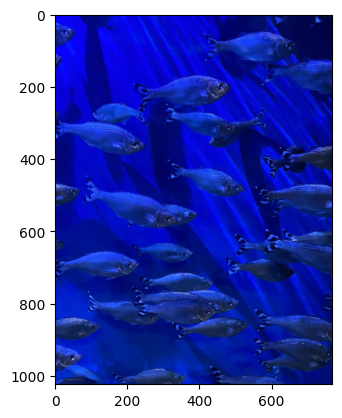

In [10]:
example_image_path = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/train/images/IMG_2274_jpeg_jpg.rf.2f319e949748145fb22dcb52bb325a0c.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

## Visualize many images

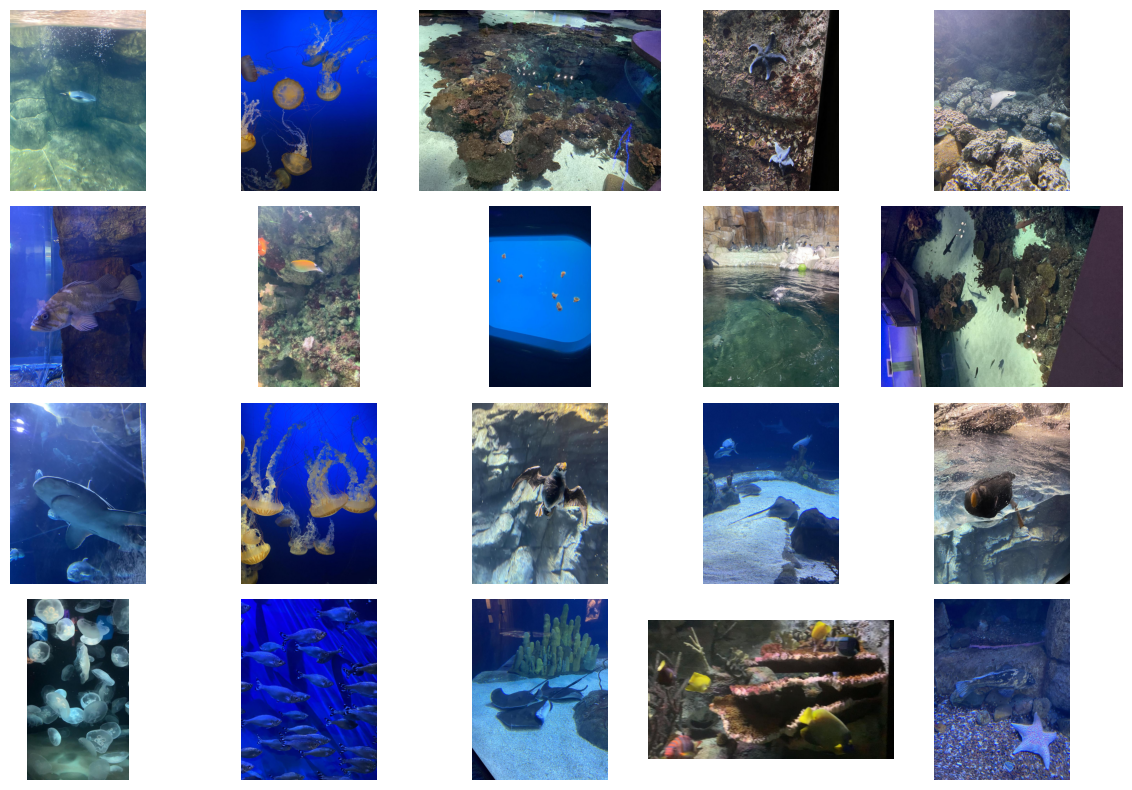

In [11]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):
    
    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
        
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()
    
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)

## Image properties

In [12]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

img_properties = get_image_properties(example_image_path)
img_properties

{'width': 768, 'height': 1024, 'channels': 3, 'dtype': dtype('uint8')}

## Dataset statistics

In [13]:
%%time
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: user 49.4 ms, sys: 56.3 ms, total: 106 ms
Wall time: 2.09 s


Mode  fish  jellyfish  penguin  puffin  shark  starfish  stingray  \
0  train   240         32       47      45    134        37        91   
1  valid    63          9       17      15     28        17        23   
2   test    30         11        7       6     14         5        10   

   Data_Volume  
0          448  
1          127  
2           63

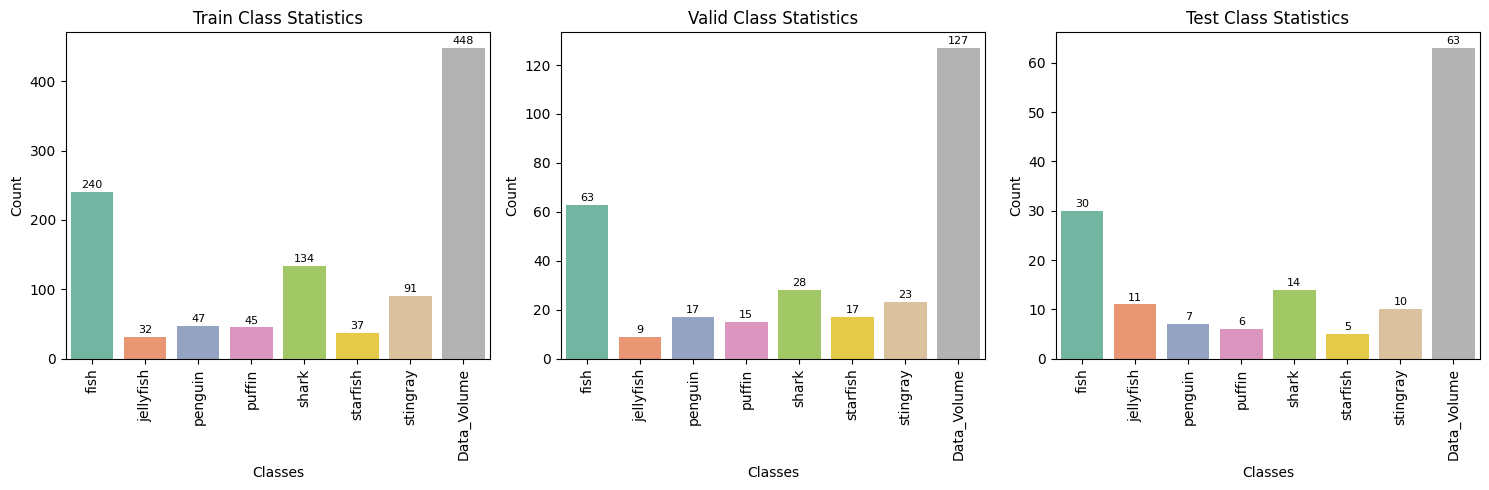

In [14]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

## Image sizes

In [15]:
# %%time

# for mode in ['train', 'valid', 'test']:
#     print(f'\nImage sizes in {mode} set:')

#     img_size = 0
#     for file in glob.glob(os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'images', '*')):

#         image = Image.open(file)

#         if image.size != img_size:
#             print(f'{image.size}')
#             img_size = image.size
#             print('\n')

# Train

[Arguments for training](https://docs.ultralytics.com/modes/train/#arguments)

In [16]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov8n.pt
Epochs:  100
Batch:  32


In [17]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

100%|██████████| 6.23M/6.23M [00:00<00:00, 75.2MB/s]


In [18]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 kB 3.7 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [19]:
# import torch
# torch.cuda.empty_cache()
# cuda_available = torch.cuda.is_available()
# print(cuda_available)

In [20]:
%%time

### train
results = model.train(
    data=os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),
    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    imgsz = (img_properties['height'], img_properties['width']),
    seed = CFG.SEED,
    device = [0,1], #[0,1], # 0
    workers=4,
    name='yolov8n_underwater')
# model.train(
#     data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

#     task = 'detect',

#     imgsz = (img_properties['height'], img_properties['width']),

#     epochs = CFG.EPOCHS,
#     batch = CFG.BATCH_SIZE,
#     optimizer = CFG.OPTIMIZER,
#     lr0 = CFG.LR,
#     lrf = CFG.LR_FACTOR,
#     weight_decay = CFG.WEIGHT_DECAY,
#     dropout = CFG.DROPOUT,
#     fraction = CFG.FRACTION,
#     patience = CFG.PATIENCE,
#     profile = CFG.PROFILE,
#     label_smoothing = CFG.LABEL_SMOOTHING,

#     name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
#     seed = CFG.SEED,
    
#     val = True,
#     amp = True,    
#     exist_ok = True,
#     resume = False,
#     device = 1, #[0,1], # 0
#     verbose = False,
# )

Ultralytics YOLOv8.1.35 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
                                                      CUDA:1 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=(1024, 768), save=True, save_period=-1, cache=False, device=[0, 1], workers=4, project=None, name=yolov8n_underwater, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=1, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fram

100%|██████████| 755k/755k [00:00<00:00, 12.0MB/s]
2024-03-28 15:16:29,759	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-03-28 15:16:30,661	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-03-28 15:16:33.284176: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 15:16:33.284289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 15:16:33.415833: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS facto

Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

2024-03-28 15:16:50.746144: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 15:16:50.746209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 15:16:50.747850: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorBoard: Start with 'tensorboard --logdir runs/detect/yolov8n_underwater', view at http://localhost:6006/
Overriding model.yaml nc=80 with nc=7
Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=1024'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /kaggle/input/aquarium-data-cots/aquarium_pretrain/train/labels... 448 images, 1 backgrounds, 0 corrupt: 100%|██████████| 448/448 [00:01<00:00, 383.45it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/aquarium-data-cots/aquarium_pretrain/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/labels... 127 images, 0 backgrounds, 0 corrupt: 100%|██████████| 127/127 [00:00<00:00, 292.02it/s]s]
train: Scanning /kaggle/input/aquarium-data-cots/aquarium_pretrain/train/labels... 318 images, 1 backgrounds, 0 corrupt:  71%|███████   | 318/448 [00:00<00:00, 547.10it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/aquarium-data-cots/aquarium_pretrain/valid is not writeable, cache not saved.


train: Scanning /kaggle/input/aquarium-data-cots/aquarium_pretrain/train/labels... 448 images, 1 backgrounds, 0 corrupt: 100%|██████████| 448/448 [00:00<00:00, 551.52it/s]


Plotting labels to runs/detect/yolov8n_underwater/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8n_underwater
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.51G      1.534      4.173      1.426        140       1024: 100%|██████████| 14/14 [00:13<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]


                   all        127        909     0.0148      0.431     0.0501     0.0284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.14G      1.503      3.207      1.338        202       1024: 100%|██████████| 14/14 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


                   all        127        909     0.0167      0.626     0.0919     0.0535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.09G      1.462       2.53      1.297        233       1024: 100%|██████████| 14/14 [00:09<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


                   all        127        909     0.0187      0.665      0.173      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       7.5G      1.436      2.185      1.307        275       1024: 100%|██████████| 14/14 [00:09<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


                   all        127        909      0.818      0.065      0.282      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.13G      1.415      2.082      1.286        209       1024: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


                   all        127        909      0.543      0.205      0.328      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.29G      1.395      1.987      1.291        138       1024: 100%|██████████| 14/14 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


                   all        127        909      0.478      0.303      0.371      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.96G      1.413      1.995      1.297        231       1024: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


                   all        127        909      0.557       0.37      0.443       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.63G      1.435      1.838      1.286        198       1024: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


                   all        127        909      0.438      0.458      0.446      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.23G      1.395      1.736      1.269        200       1024: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


                   all        127        909        0.5       0.46      0.489      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.11G      1.348      1.686      1.248        181       1024: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


                   all        127        909      0.405      0.437      0.405      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.25G      1.315       1.59      1.257        189       1024: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


                   all        127        909      0.458      0.449      0.444      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.27G      1.335      1.581      1.237        209       1024: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


                   all        127        909      0.497      0.549      0.526      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.15G      1.368      1.477      1.251        175       1024: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


                   all        127        909      0.602      0.498      0.536        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.44G      1.281      1.421      1.201        242       1024: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


                   all        127        909      0.566      0.532      0.546      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.43G      1.262      1.365      1.176        215       1024: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


                   all        127        909      0.563       0.55      0.542      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.63G      1.317      1.385      1.236        160       1024: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


                   all        127        909      0.647      0.486      0.547      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         7G      1.293      1.375      1.216        235       1024: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]


                   all        127        909      0.653      0.622      0.627      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.91G      1.244       1.34      1.195        149       1024: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]


                   all        127        909      0.733      0.539      0.606      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.58G      1.245      1.277      1.169        241       1024: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


                   all        127        909      0.685      0.591      0.624      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.23G      1.284      1.296      1.205        128       1024: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


                   all        127        909      0.708      0.583      0.642      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.33G      1.226      1.245      1.162        184       1024: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]


                   all        127        909      0.739      0.619       0.69        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.06G      1.239      1.259      1.186         96       1024: 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


                   all        127        909      0.691      0.541      0.619      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.29G      1.213      1.191      1.174        288       1024: 100%|██████████| 14/14 [00:08<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]


                   all        127        909      0.713       0.64      0.692      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.66G      1.195      1.136      1.169        210       1024: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


                   all        127        909      0.706      0.644      0.661      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.96G       1.21      1.154      1.157        244       1024: 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]


                   all        127        909       0.72      0.591      0.639      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.32G      1.241      1.125      1.168        169       1024: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]


                   all        127        909      0.745      0.617      0.677      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.23G      1.237      1.121      1.173        143       1024: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]


                   all        127        909      0.712      0.637      0.666        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       6.2G      1.145      1.079      1.156        146       1024: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


                   all        127        909      0.643      0.622      0.644      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.35G      1.197      1.051       1.14        158       1024: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]


                   all        127        909      0.689      0.562      0.627      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.09G        1.2      1.086      1.148        181       1024: 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


                   all        127        909      0.751      0.613      0.676      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.04G      1.222      1.079      1.166        246       1024: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


                   all        127        909      0.795      0.565      0.674      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.75G      1.205       1.07      1.177        166       1024: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]


                   all        127        909      0.745      0.625       0.68      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.68G      1.197     0.9883      1.167        196       1024: 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]


                   all        127        909       0.78       0.63      0.697      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.04G      1.167     0.9951      1.121        212       1024: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


                   all        127        909      0.748      0.655       0.71       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.83G      1.154     0.9972      1.134        237       1024: 100%|██████████| 14/14 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


                   all        127        909       0.71      0.683      0.705      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.65G      1.172     0.9479      1.114        230       1024: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]


                   all        127        909      0.693       0.67      0.697      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       6.3G      1.153     0.9829      1.127        205       1024: 100%|██████████| 14/14 [00:08<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


                   all        127        909       0.76      0.589      0.671      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.06G      1.089     0.9081      1.093        162       1024: 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


                   all        127        909      0.714      0.662      0.696      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.74G      1.138     0.9217      1.117        160       1024: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


                   all        127        909      0.803      0.647      0.713      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.97G      1.098     0.9136      1.096        234       1024: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


                   all        127        909       0.76      0.674      0.714      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.15G      1.105     0.8682      1.074        160       1024: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


                   all        127        909      0.761      0.665      0.722      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.07G      1.075     0.8863      1.088        195       1024: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


                   all        127        909      0.762      0.656      0.708      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.57G      1.147     0.8951      1.104        271       1024: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


                   all        127        909      0.769      0.616      0.713      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.08G      1.095     0.8787      1.095         95       1024: 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


                   all        127        909      0.735      0.712       0.71      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.09G      1.091     0.8314      1.089        175       1024: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


                   all        127        909      0.761      0.686      0.731      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.67G      1.083     0.8629      1.097        135       1024: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]


                   all        127        909      0.746      0.664      0.713      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.66G      1.015      0.791      1.062        256       1024: 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


                   all        127        909      0.766      0.655      0.717      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.13G      1.076     0.8303      1.095        141       1024: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]


                   all        127        909      0.753      0.678      0.741      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.42G      1.029     0.7898       1.05        282       1024: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


                   all        127        909      0.707      0.665      0.702       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.34G      1.038     0.7685      1.073        280       1024: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


                   all        127        909      0.773      0.636      0.709      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.91G      1.065     0.8029      1.077        192       1024: 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


                   all        127        909      0.769      0.629      0.714      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.71G      1.047     0.7832      1.053        149       1024: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]


                   all        127        909      0.764      0.697      0.734      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.28G      1.065     0.7958      1.066        182       1024: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


                   all        127        909      0.745       0.65      0.699      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.08G      1.023     0.7576      1.058        178       1024: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


                   all        127        909       0.75      0.668      0.714      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.31G      1.051     0.7856       1.08        261       1024: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]


                   all        127        909      0.783      0.652      0.726      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.22G       1.03     0.7781      1.079        138       1024: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


                   all        127        909      0.755      0.677      0.732      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.52G      1.002     0.7406      1.054        222       1024: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


                   all        127        909       0.79      0.604       0.71      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       6.2G     0.9938     0.7635      1.061        197       1024: 100%|██████████| 14/14 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


                   all        127        909      0.757      0.669      0.711      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.57G      1.013     0.7685      1.064        242       1024: 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


                   all        127        909      0.804       0.65      0.733      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         6G      1.038      0.743      1.061        332       1024: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


                   all        127        909      0.775      0.667      0.733      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.55G     0.9783     0.7375      1.042        211       1024: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


                   all        127        909      0.759      0.687       0.73      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.77G     0.9885     0.7401      1.056        275       1024: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


                   all        127        909      0.766      0.686      0.723      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.21G      1.021     0.7357      1.046        205       1024: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]


                   all        127        909      0.768      0.699      0.731      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.17G     0.9737     0.7167      1.045        180       1024: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]


                   all        127        909       0.79      0.666      0.746      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.35G     0.9862     0.7208      1.035        281       1024: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]


                   all        127        909      0.807      0.666      0.745      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.99G     0.9977     0.7074      1.049        231       1024: 100%|██████████| 14/14 [00:08<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]


                   all        127        909      0.779      0.645      0.714      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.77G       1.02     0.7104      1.031        243       1024: 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


                   all        127        909      0.796      0.663      0.725      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.82G     0.9796     0.6893      1.032        205       1024: 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


                   all        127        909      0.731      0.709      0.737      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.65G     0.9682      0.683       1.03        195       1024: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


                   all        127        909      0.811      0.634      0.721      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.16G     0.9481     0.6686      1.019        229       1024: 100%|██████████| 14/14 [00:08<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


                   all        127        909      0.749      0.697       0.73       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.82G     0.9374     0.6603      1.014        182       1024: 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


                   all        127        909      0.792      0.687      0.744      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.64G     0.9453     0.6762      1.027        210       1024: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]


                   all        127        909      0.774      0.688      0.713      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.46G     0.9506     0.6746      1.029        246       1024: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


                   all        127        909      0.758      0.678      0.722      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.58G     0.9595     0.6688      1.031        188       1024: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]


                   all        127        909      0.852      0.655      0.745       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.19G     0.9447     0.6661      1.022        218       1024: 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


                   all        127        909        0.8      0.704      0.749      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.72G     0.9911     0.6777       1.04        188       1024: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


                   all        127        909      0.785      0.703      0.753      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.28G     0.8996      0.646      1.001        293       1024: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


                   all        127        909      0.804      0.694      0.752      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.13G     0.9124     0.6532      1.014        177       1024: 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


                   all        127        909      0.776      0.682      0.726      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.55G      0.887     0.6505      1.004        142       1024: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


                   all        127        909      0.813      0.662      0.725      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.18G     0.9437     0.6525      1.018        133       1024: 100%|██████████| 14/14 [00:09<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


                   all        127        909      0.811      0.657      0.728      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.12G     0.9198     0.6312      1.013        272       1024: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


                   all        127        909      0.801      0.691      0.755      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.32G     0.9184     0.6376      1.003        142       1024: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


                   all        127        909      0.807      0.688      0.757      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.99G     0.9213     0.6365     0.9969        153       1024: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]


                   all        127        909      0.831      0.674      0.765      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.07G     0.9152     0.6417      1.022        192       1024: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


                   all        127        909      0.811      0.692      0.762      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       6.9G     0.8856     0.6102      1.002        160       1024: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]


                   all        127        909      0.771      0.708      0.757      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.09G     0.8772     0.6028     0.9886        265       1024: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


                   all        127        909      0.811      0.681      0.753       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.33G     0.8711     0.6117     0.9968        158       1024: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


                   all        127        909      0.804      0.699      0.762      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.06G     0.9032     0.6133      1.029        224       1024: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


                   all        127        909      0.783      0.722      0.758       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.59G      0.912      0.629      1.017        118       1024: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


                   all        127        909      0.791      0.689      0.759      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.39G     0.9322     0.6274      1.007        181       1024: 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


                   all        127        909      0.819      0.705      0.764      0.473
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


  0%|          | 0/14 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.96G     0.9163     0.6471     0.9971         83       1024: 100%|██████████| 14/14 [00:12<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


                   all        127        909      0.766      0.706       0.74      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.96G     0.8982     0.6216      0.978         82       1024: 100%|██████████| 14/14 [00:06<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


                   all        127        909      0.821      0.687      0.763      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.16G     0.8015     0.5656     0.9542        179       1024: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


                   all        127        909      0.815      0.699      0.764      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.19G     0.8448     0.5639     0.9709        112       1024: 100%|██████████| 14/14 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]


                   all        127        909      0.814      0.702      0.751      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.71G     0.8427     0.5438     0.9747        142       1024: 100%|██████████| 14/14 [00:07<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]


                   all        127        909      0.794      0.724      0.757      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.97G     0.8177     0.5406     0.9629        136       1024: 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


                   all        127        909      0.808      0.705      0.753      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.19G     0.8703     0.5555     0.9739        136       1024: 100%|██████████| 14/14 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


                   all        127        909      0.806      0.697      0.754      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.29G        0.8     0.5372     0.9511        124       1024: 100%|██████████| 14/14 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]


                   all        127        909      0.802      0.705      0.755      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.19G     0.8119     0.5543     0.9648         56       1024: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


                   all        127        909      0.794      0.706      0.755      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.91G     0.7907     0.5343      0.963        158       1024: 100%|██████████| 14/14 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]


                   all        127        909      0.804      0.702      0.753      0.462

100 epochs completed in 0.336 hours.
Optimizer stripped from runs/detect/yolov8n_underwater/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolov8n_underwater/weights/best.pt, 6.3MB

Validating runs/detect/yolov8n_underwater/weights/best.pt...
Ultralytics YOLOv8.1.35 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
                                                      CUDA:1 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007013 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


                   all        127        909      0.809      0.698      0.761      0.477
                  fish        127        459      0.835      0.748       0.82      0.474
             jellyfish        127        155      0.854      0.768      0.892      0.532
               penguin        127        104      0.651       0.74      0.697      0.325
                puffin        127         74      0.741      0.501      0.573      0.321
                 shark        127         57      0.827      0.672      0.766      0.493
              starfish        127         27      0.922      0.667      0.803      0.647
              stingray        127         33      0.832      0.788       0.78      0.549
Speed: 0.5ms preprocess, 4.6ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/detect/yolov8n_underwater
CPU times: user 11 s, sys: 1.62 s, total: 12.6 s
Wall time: 21min 14s


# Export

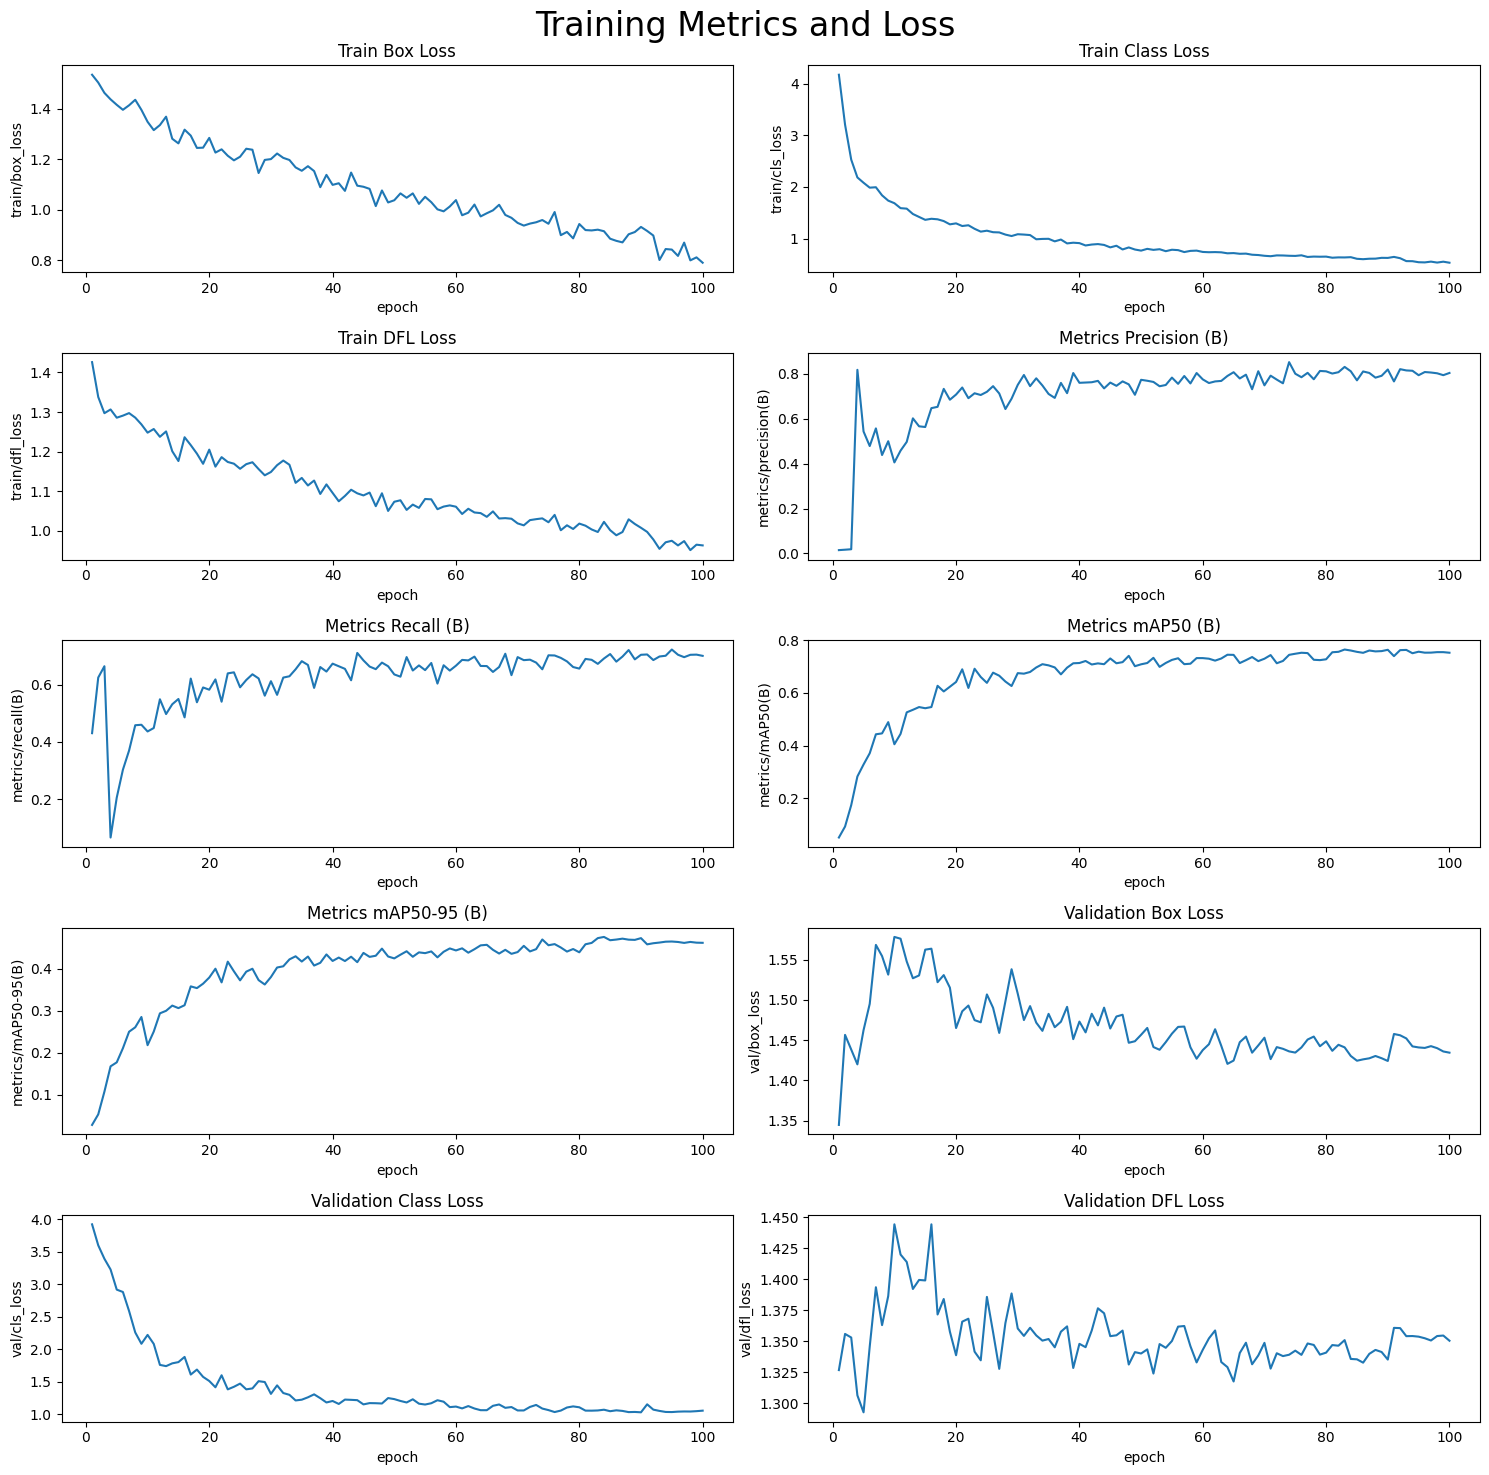

In [21]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/runs/detect/yolov8n_underwater/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

# Evaluation

In [23]:
# Loading the best performing model
model = YOLO('/kaggle/working/runs/detect/yolov8n_underwater/weights/best.pt')

# Evaluating the model on test dataset
metrics = model.val(conf=0.25, split='test')

Ultralytics YOLOv8.1.35 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007013 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/labels... 63 images, 0 backgrounds, 0 corrupt: 100%|██████████| 63/63 [00:00<00:00, 276.19it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/aquarium-data-cots/aquarium_pretrain/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.07s/it]


                   all         63        584      0.841      0.675      0.791      0.527
                  fish         63        249      0.783      0.707       0.78      0.512
             jellyfish         63        154      0.893       0.74      0.847      0.592
               penguin         63         82      0.832      0.756      0.821      0.397
                puffin         63         35      0.712      0.314      0.562      0.351
                 shark         63         38      0.845      0.763      0.847      0.582
              starfish         63         11      0.907      0.727      0.836      0.577
              stingray         63         15      0.915      0.715      0.844      0.675
Speed: 1.6ms preprocess, 82.2ms inference, 0.0ms loss, 32.5ms postprocess per image
Results saved to runs/detect/val


In [24]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")    
print(f"Mean Average Precision @ .50   : {metrics.box.map50}") 
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

Mean Average Precision @.5:.95 : 0.5266643634296625
Mean Average Precision @ .50   : 0.791030772127706
Mean Average Precision @ .70   : 0.5613567887977652


# Test model



image 1/63 /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images/IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.jpg: 1024x768 (no detections), 68.4ms
image 2/63 /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images/IMG_2301_jpeg_jpg.rf.2c19ae5efbd1f8611b5578125f001695.jpg: 1024x768 19 penguins, 11.2ms
image 3/63 /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images/IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg: 1024x768 9 penguins, 11.3ms
image 4/63 /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images/IMG_2347_jpeg_jpg.rf.7c71ac4b9301eb358cd4a832844dedcb.jpg: 1024x768 2 penguins, 11.3ms
image 5/63 /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images/IMG_2354_jpeg_jpg.rf.396e872c7fb0a95e911806986995ee7a.jpg: 1024x768 6 penguins, 11.3ms
image 6/63 /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images/IMG_2371_jpeg_jpg.rf.54505f60b6706da151c164188c305849.jpg: 1024x768 4 fishs, 11.2ms
image 7/63 /kaggle/input/aquar

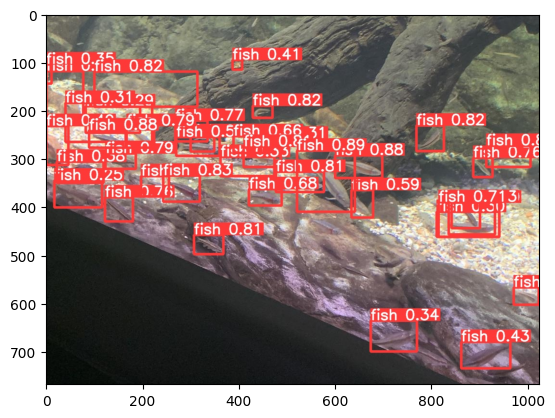

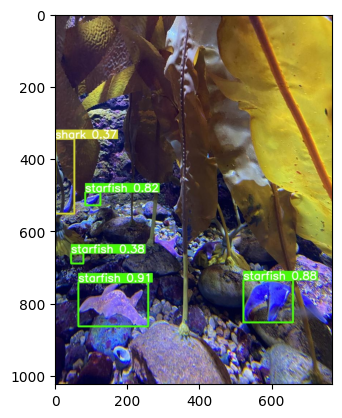

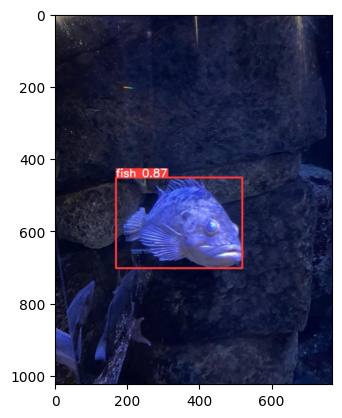

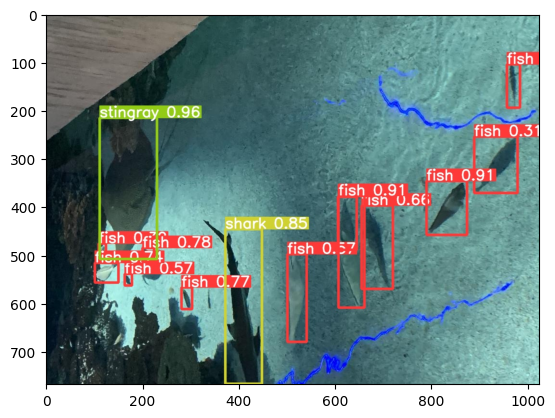

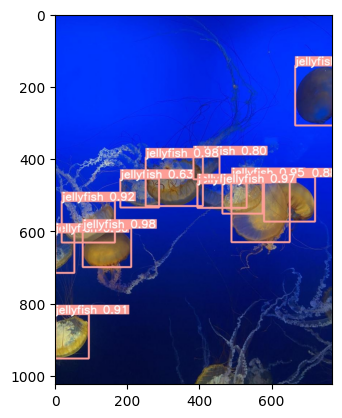

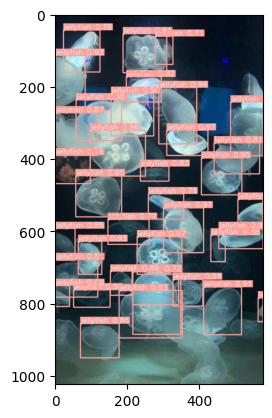

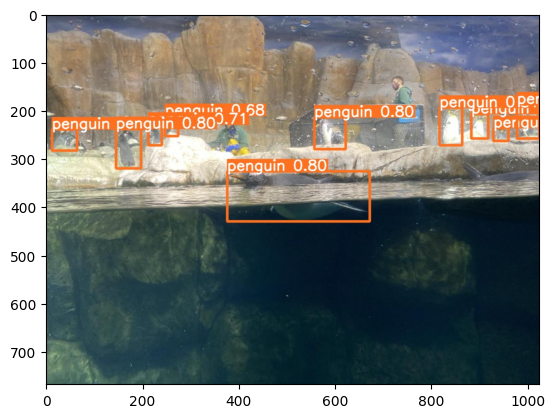

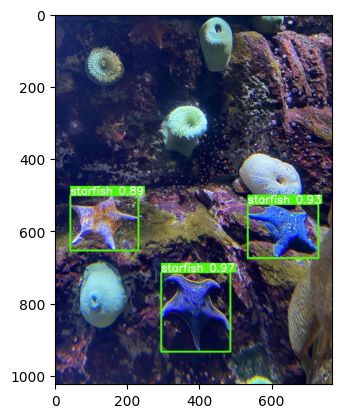

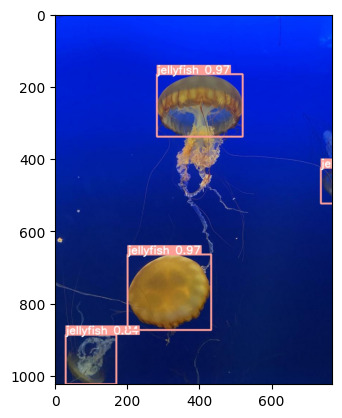

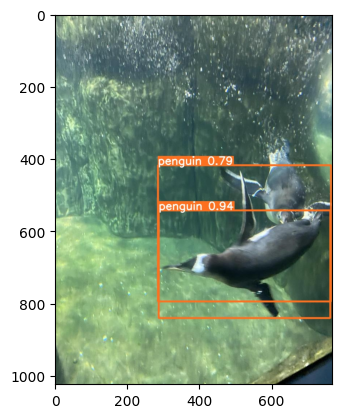

In [26]:
results = model.predict(source=os.path.join(CFG.CUSTOM_DATASET_DIR, 'test', 'images'), save=True)
%matplotlib inline

predicitions = glob.glob(os.path.join(CFG.OUTPUT_DIR, 'runs/detect/predict', '*'))

n = 10

for i in range(n):
    idx = np.random.randint(0, len(predicitions))
    image = Image.open(predicitions[idx])
    plt.imshow(image)
    plt.grid(False)
    plt.show()

# Retrain model use augmention data

In [29]:
path = '/kaggle/input/aquarium-pretrain-augmention/aquarium_pretrain_augmention'
dict_file = {
    'train': os.path.join(path, 'train'),
    'val': os.path.join(path, 'valid'),
    'nc': CFG.NUM_CLASSES,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data_aug.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [32]:
### read yaml file created

def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data_aug.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- fish
- jellyfish
- penguin
- puffin
- shark
- starfish
- stingray
nc: 7
train: /kaggle/input/aquarium-pretrain-augmention/aquarium_pretrain_augmention/train
val: /kaggle/input/aquarium-pretrain-augmention/aquarium_pretrain_augmention/valid



In [ ]:
#retrain use model best.pt
model = YOLO('/kaggle/working/runs/detect/yolov8n_underwater/weights/best.pt')

results_aug = model.train(
    data=os.path.join(CFG.OUTPUT_DIR, 'data_aug.yaml'),
    epochs = 200,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    imgsz = (img_properties['height'], img_properties['width']),
    seed = CFG.SEED,
    device = [0,1], #[0,1], # 0
    workers=4,
    name='yolov8n_underwater_aug1')

Ultralytics YOLOv8.1.35 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
                                                      CUDA:1 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/runs/detect/yolov8n_underwater/weights/best.pt, data=/kaggle/working/data_aug.yaml, epochs=200, time=None, patience=100, batch=32, imgsz=(1024, 768), save=True, save_period=-1, cache=False, device=[0, 1], workers=4, project=None, name=yolov8n_underwater_aug1, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=1, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classe

2024-03-28 15:52:55.147715: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 15:52:55.147767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 15:52:55.149218: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorBoard: Start with 'tensorboard --logdir runs/detect/yolov8n_underwater_aug1', view at http://localhost:6006/
Transferred 355/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
